In [19]:
import pandas as pd  # Importing the pandas library for data manipulation and analysis

# Load the dataset into a DataFrame
data = pd.read_csv('weatherHistory.csv')

# Convert the 'Formatted Date' column to datetime format (in UTC)
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)

# Check for missing values in the DataFrame
missing_values = data.isnull().sum()  # Count the number of missing values in each column
print("Missing value counts:\n", missing_values[missing_values > 0])  # Print only columns with missing values

# Fill or drop missing values if necessary
# Example: Fill missing temperature values with the mean temperature
data['Temperature (C)'] = data['Temperature (C)'].fillna(data['Temperature (C)'].mean())

# Fill missing humidity values with the mean humidity
data['Humidity'] = data['Humidity'].fillna(data['Humidity'].mean())

# Fill missing values in 'Precip Type' column with 'no_precip' as a placeholder
data['Precip Type'] = data['Precip Type'].fillna('no_precip')

# Display the updated information of the DataFrame
print(data.info())  # This shows the data types and counts of non-null values for each column


Missing value counts:
 Precip Type    517
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               96453 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      9

In [20]:
# Remove unnecessary columns from the DataFrame
data_cleaned = data[['Formatted Date', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)']]

# Display the first few rows of the cleaned DataFrame
print(data_cleaned.head())  # This prints the first five rows of the DataFrame to give an overview of the data


             Formatted Date  Temperature (C)  Humidity  Wind Speed (km/h)
0 2006-03-31 22:00:00+00:00         9.472222      0.89            14.1197
1 2006-03-31 23:00:00+00:00         9.355556      0.86            14.2646
2 2006-04-01 00:00:00+00:00         9.377778      0.89             3.9284
3 2006-04-01 01:00:00+00:00         8.288889      0.83            14.1036
4 2006-04-01 02:00:00+00:00         8.755556      0.83            11.0446


In [21]:
# Resample the DataFrame to group the data by day and calculate the daily mean
daily_data = data_cleaned.resample('D', on='Formatted Date').mean()

# Display the first few rows of the daily aggregated DataFrame
print(daily_data.head())  # This prints the first five rows of the daily_data DataFrame to show the results of the resampling


                           Temperature (C)  Humidity  Wind Speed (km/h)
Formatted Date                                                         
2005-12-31 00:00:00+00:00         0.577778  0.890000          17.114300
2006-01-01 00:00:00+00:00         4.075000  0.817083          21.229192
2006-01-02 00:00:00+00:00         5.263194  0.847083          17.824713
2006-01-03 00:00:00+00:00         2.340509  0.897083           7.726658
2006-01-04 00:00:00+00:00         2.251852  0.906667          12.152817


In [22]:
# Check for missing values in the daily aggregated DataFrame
missing_values_daily = daily_data.isnull().sum()  # Count the number of missing values for each column
print("Number of missing values:\n", missing_values_daily[missing_values_daily > 0])  # Print only columns with missing values

# If there are any missing values, fill them using forward fill method
daily_data.ffill(inplace=True)  # Fill missing values with the last known value (forward fill)


Number of missing values:
 Series([], dtype: int64)


In [23]:
# Adding previous temperature and humidity values to the daily_data DataFrame
daily_data['Prev Temperature'] = daily_data['Temperature (C)'].shift(1)  # Shift the 'Temperature (C)' column down by 1 row to create a new column for the previous day's temperature
daily_data['Prev Humidity'] = daily_data['Humidity'].shift(1)  # Shift the 'Humidity' column down by 1 row to create a new column for the previous day's humidity

# Display the first few rows of the updated DataFrame
print(daily_data.head())  # Print the first five rows of the DataFrame to verify the changes


                           Temperature (C)  Humidity  Wind Speed (km/h)  \
Formatted Date                                                            
2005-12-31 00:00:00+00:00         0.577778  0.890000          17.114300   
2006-01-01 00:00:00+00:00         4.075000  0.817083          21.229192   
2006-01-02 00:00:00+00:00         5.263194  0.847083          17.824713   
2006-01-03 00:00:00+00:00         2.340509  0.897083           7.726658   
2006-01-04 00:00:00+00:00         2.251852  0.906667          12.152817   

                           Prev Temperature  Prev Humidity  
Formatted Date                                              
2005-12-31 00:00:00+00:00               NaN            NaN  
2006-01-01 00:00:00+00:00          0.577778       0.890000  
2006-01-02 00:00:00+00:00          4.075000       0.817083  
2006-01-03 00:00:00+00:00          5.263194       0.847083  
2006-01-04 00:00:00+00:00          2.340509       0.897083  


In [24]:
# Separating dependent and independent variables
X = daily_data[['Prev Temperature', 'Prev Humidity', 'Wind Speed (km/h)']].copy()  # Create a copy of the DataFrame containing independent variables
y = daily_data['Temperature (C)']  # Define the dependent variable we want to predict, which is the temperature

# Checking for missing values and dropping them if necessary
X.dropna(inplace=True)  # Remove any rows in X that contain NaN values to ensure the dataset is clean
y = y[X.index]  # Align y with the index of X to ensure they correspond to the same rows after dropping NaN values


In [25]:
from sklearn.model_selection import train_test_split  # Import the train_test_split function from scikit-learn

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# This function splits the features (X) and target variable (y) into training and test sets.
# 'test_size=0.2' indicates that 20% of the data will be reserved for testing, while 80% will be used for training.
# 'random_state=42' ensures that the split is reproducible, meaning the same random split will be generated each time the code is run.

# Checking the sizes of the training and testing sets
print(f"Training set size: {X_train.shape[0]}")  # Print the number of samples in the training set
print(f"Test set size: {X_test.shape[0]}")       # Print the number of samples in the test set


Training set size: 3214
Test set size: 804


In [26]:
from sklearn.linear_model import LinearRegression  # Import the LinearRegression class from scikit-learn

# Creating the model
model = LinearRegression()  # Instantiate the LinearRegression model object

# Training the model
model.fit(X_train, y_train)  # Fit the model to the training data (X_train and y_train)

# Making predictions on the training set
y_train_pred = model.predict(X_train)  # Use the trained model to predict the target variable on the training set

# Making predictions on the test set
y_test_pred = model.predict(X_test)  # Use the trained model to predict the target variable on the test set


In [28]:
from sklearn.metrics import mean_squared_error, r2_score  # Import the metrics for evaluation

# Calculating error metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)  # Compute Mean Squared Error (MSE) for the training set
train_r2 = r2_score(y_train, y_train_pred)  # Compute R-squared (R²) score for the training set

# Calculating error metrics for the test set
test_mse = mean_squared_error(y_test, y_test_pred)  # Compute Mean Squared Error (MSE) for the test set
test_r2 = r2_score(y_test, y_test_pred)  # Compute R-squared (R²) score for the test set

# Printing the results for the training set
print(f"Training Set - Mean Squared Error (MSE): {train_mse:.2f}")  # Output the MSE for the training set
print(f"Training Set - R^2 Score: {train_r2:.2f}")  # Output the R² score for the training set

# Printing the results for the test set
print(f"Test Set - Mean Squared Error (MSE): {test_mse:.2f}")  # Output the MSE for the test set
print(f"Test Set - R^2 Score: {test_r2:.2f}")  # Output the R² score for the test set


Training Set - Mean Squared Error (MSE): 4.81
Training Set - R^2 Score: 0.94
Test Set - Mean Squared Error (MSE): 4.54
Test Set - R^2 Score: 0.94


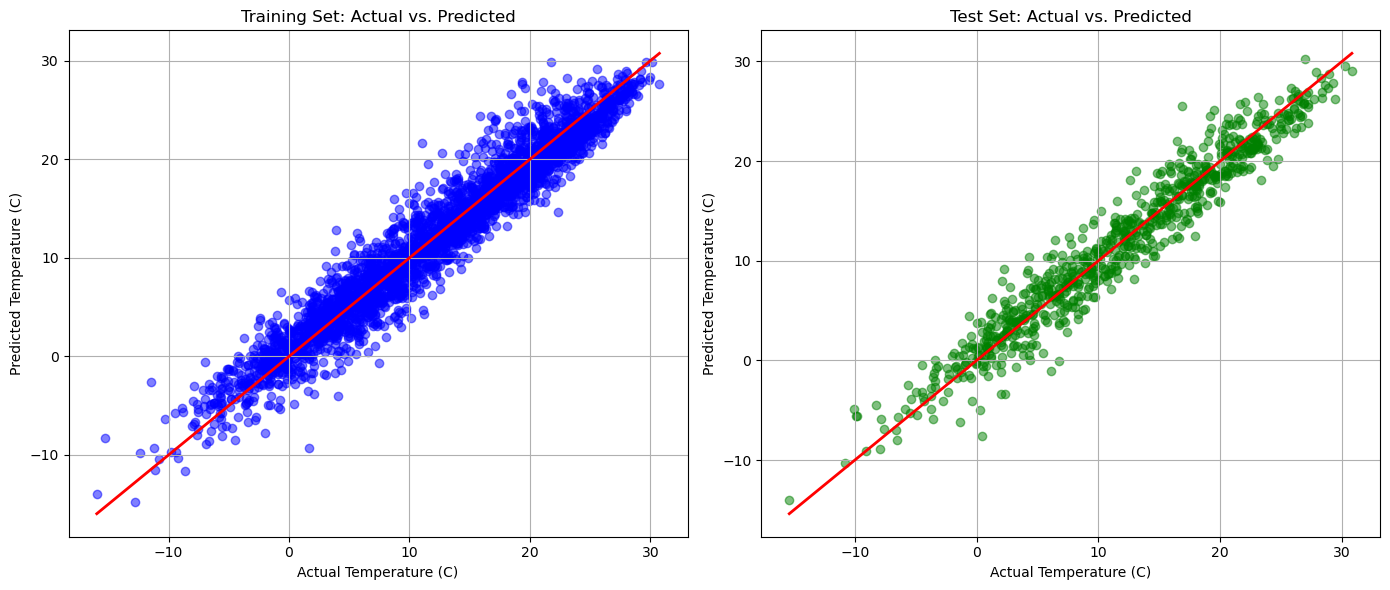

In [29]:
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting

# Visualizing predictions on the training set
plt.figure(figsize=(14, 6))  # Set the figure size

# Training set
plt.subplot(1, 2, 1)  # Create a subplot for the training set
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)  # Scatter plot of actual vs predicted temperatures
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', lw=2)  # Reference line for perfect predictions
plt.title('Training Set: Actual vs. Predicted')  # Title for the training set plot
plt.xlabel('Actual Temperature (C)')  # X-axis label
plt.ylabel('Predicted Temperature (C)')  # Y-axis label
plt.grid()  # Enable grid for better visualization

# Test set
plt.subplot(1, 2, 2)  # Create a subplot for the test set
plt.scatter(y_test, y_test_pred, color='green', alpha=0.5)  # Scatter plot of actual vs predicted temperatures
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Reference line for perfect predictions
plt.title('Test Set: Actual vs. Predicted')  # Title for the test set plot
plt.xlabel('Actual Temperature (C)')  # X-axis label
plt.ylabel('Predicted Temperature (C)')  # Y-axis label
plt.grid()  # Enable grid for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


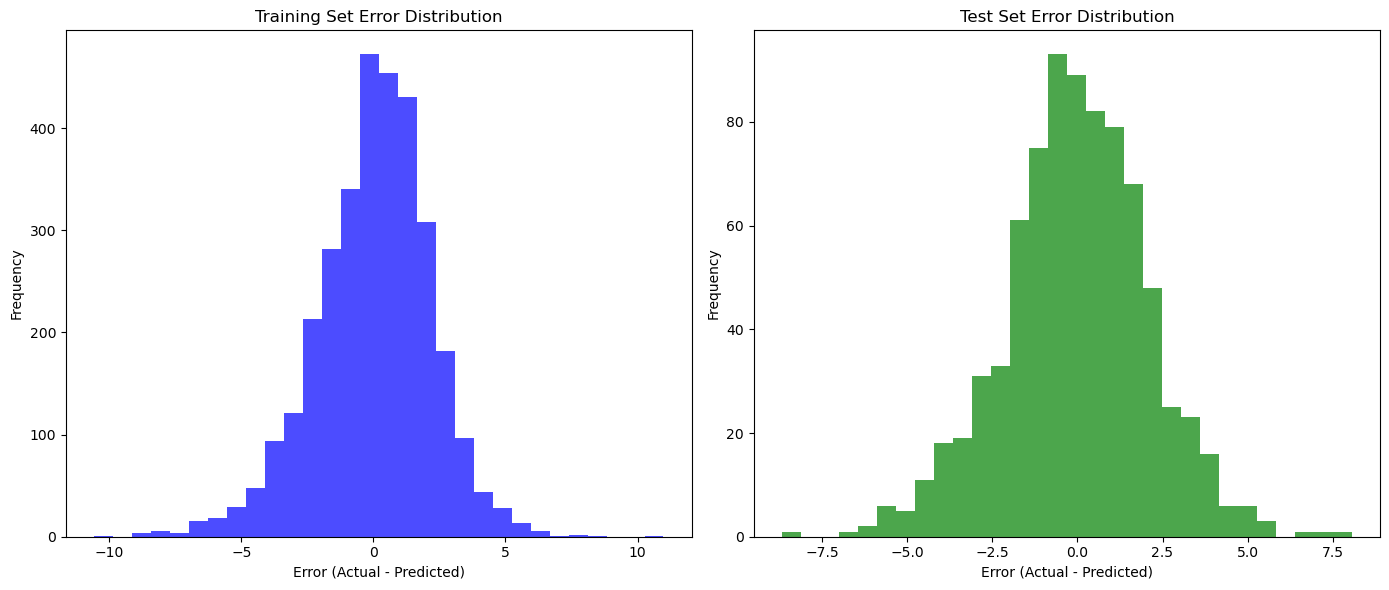

In [30]:
# Error calculation
train_errors = y_train - y_train_pred  # Calculate errors for the training set
test_errors = y_test - y_test_pred  # Calculate errors for the test set

# Visualizing the distribution of errors
plt.figure(figsize=(14, 6))  # Set the figure size

# Training set errors
plt.subplot(1, 2, 1)  # Create a subplot for training set errors
plt.hist(train_errors, bins=30, color='blue', alpha=0.7)  # Histogram of training set errors
plt.title('Training Set Error Distribution')  # Title for the training set error distribution
plt.xlabel('Error (Actual - Predicted)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label

# Test set errors
plt.subplot(1, 2, 2)  # Create a subplot for test set errors
plt.hist(test_errors, bins=30, color='green', alpha=0.7)  # Histogram of test set errors
plt.title('Test Set Error Distribution')  # Title for the test set error distribution
plt.xlabel('Error (Actual - Predicted)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


In [31]:
# Printing the results for the training set
train_results = pd.DataFrame({  # Create a DataFrame to hold the training results
    'Actual Temperature (C)': y_train,  # Actual temperatures from the training set
    'Predicted Temperature (C)': y_train_pred,  # Predicted temperatures from the training set
    'Error': y_train - y_train_pred  # Calculate the error (Actual - Predicted)
})

print("Training Set Prediction Results:")  # Print statement for the training results
print(train_results.head())  # Display the first few rows of the training results

# Printing the results for the test set
test_results = pd.DataFrame({  # Create a DataFrame to hold the test results
    'Actual Temperature (C)': y_test,  # Actual temperatures from the test set
    'Predicted Temperature (C)': y_test_pred,  # Predicted temperatures from the test set
    'Error': y_test - y_test_pred  # Calculate the error (Actual - Predicted)
})

print("\nTest Set Prediction Results:")  # Print statement for the test results
print(test_results.head())  # Display the first few rows of the test results


Training Set Prediction Results:
                           Actual Temperature (C)  Predicted Temperature (C)  \
Formatted Date                                                                 
2015-11-23 00:00:00+00:00                2.678472                   3.698924   
2013-04-15 00:00:00+00:00               10.891435                  12.200944   
2015-01-04 00:00:00+00:00                2.574074                   1.460342   
2008-12-11 00:00:00+00:00                5.844907                   1.221126   
2014-11-24 00:00:00+00:00                4.150231                   6.242012   

                              Error  
Formatted Date                       
2015-11-23 00:00:00+00:00 -1.020452  
2013-04-15 00:00:00+00:00 -1.309509  
2015-01-04 00:00:00+00:00  1.113733  
2008-12-11 00:00:00+00:00  4.623782  
2014-11-24 00:00:00+00:00 -2.091781  

Test Set Prediction Results:
                           Actual Temperature (C)  Predicted Temperature (C)  \
Formatted Date                